## _Track Building (Reco.) from GNN Score_

- after GNN Stage, one has evaluation (_**i.e.** edge score_) of GNN on test data.
- the GNN evaluation data (_**i.e.** edge score_) is stored in _`run/gnn_evaluation/test`_.
- use _`trkx_from_gnn.py`_ to reconstruct tracks saved to _`run/trkx_from_gnn`_ folder.

Following the breakdown of _`trkx_from_gnn.py`_ script.

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import time

In [4]:
from sklearn.cluster import DBSCAN
from multiprocessing import Pool
from functools import partial

In [5]:
# select a device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
sys.path.append('..')

In [7]:
# functions from draw_utils for drawing
from LightningModules.Processing.utils.draw_utils import draw_proc_event, cylindrical_to_cartesian

### _(1) Processed Data_

In [8]:
inputdir="../run_all/feature_store_pred"
proc_files = sorted(glob.glob(os.path.join(inputdir, "*")))
proc_files[:5]

['../run_all/feature_store_pred/110000',
 '../run_all/feature_store_pred/110001',
 '../run_all/feature_store_pred/110002',
 '../run_all/feature_store_pred/110003',
 '../run_all/feature_store_pred/110004']

In [9]:
feature_data = torch.load(proc_files[1], map_location=device)
print("Length of Data: {}".format(len(feature_data)))

Length of Data: 10


In [10]:
# event ID
event_id = int(os.path.basename(feature_data.event_file)[-10:])
print("Event ID: {}".format(event_id))

Event ID: 110001


In [11]:
# number of tracks
track_ids = np.unique(feature_data.pid)
print("Track IDs: {}".format(track_ids))

Track IDs: [ 1.  2.  3.  4.  5.  6.  7.  9. 10.]


In [12]:
# input to GNN (processed data)
feature_data

Data(x=[127, 3], pid=[127], layers=[127], event_file='/home/adeak977/current/3_deeptrkx/ctd2022/train_all1/event0000110001', hid=[127], pt=[127], modulewise_true_edges=[2, 118], layerwise_true_edges=[2, 125], edge_index=[2, 555], y_pid=[555])

### _(2) GNN Processed Data_

In [13]:
inputdir="../run_all/gnn_processed/pred"
gnn_eval_files = sorted(glob.glob(os.path.join(inputdir, "*")))
gnn_eval_files[:5]

['../run_all/gnn_processed/pred/110000',
 '../run_all/gnn_processed/pred/110001',
 '../run_all/gnn_processed/pred/110002',
 '../run_all/gnn_processed/pred/110003',
 '../run_all/gnn_processed/pred/110004']

In [14]:
gnn_eval_data = torch.load(gnn_eval_files[1], map_location=device)
print("Length of Data: {}".format(len(gnn_eval_data)))

Length of Data: 11


In [15]:
# event ID
event_id = int(os.path.basename(gnn_eval_data.event_file)[-10:])
print("Event ID: {}".format(event_id))

Event ID: 110001


In [16]:
# number of tracks
track_ids = np.unique(gnn_eval_data.pid)
print("Track IDs: {}".format(track_ids))

Track IDs: [ 1.  2.  3.  4.  5.  6.  7.  9. 10.]


In [17]:
# evaluation score (only first 5 edge scores)
scores = gnn_eval_data.scores[:5].numpy()
print("Edge Score: {}".format(scores))

Edge Score: [9.9978536e-01 6.0855685e-04 1.7747468e-04 4.6272093e-04 9.9992490e-01]


### _(3) Tracks from GNN_

- We have everything in _`run/gnn_evaluation/test`_, _**i.e.**_ input feature data (from Processing Stage) and evaluation score (from GNN Stage).
- The _score_ from GNN Stage is also called the _edge score_ or _evaluation score_, etc.

Here is breakdown of _`tracks_from_gnn.py`_ script.

In [18]:
inputdir="../run_all/gnn_processed/pred"          # input from GNN stage as in test/pred
outputdir="../run_all/gnn_segmenting/seg_test"    # output of trkx_from_gnn.sh i.e. TrackCands

In [19]:
# Output dir for Track Building/Reco
os.makedirs(outputdir, exist_ok=True)

In [20]:
# (i) GNN Processed Data

# use os.listdir to fetch files
# all_events = os.listdir(inputdir) # get a list of files
# all_events = sorted([os.path.join(inputdir, event) for event in all_events]) # list-comprehension to join path with files & sort
# all_events[:10]

In [21]:
# (ii) GNN Processed Data

# use glob.glob to fetch files (Note: glob.glob is wrapper around os.listdir)
gnn_eval_files = sorted(glob.glob(os.path.join(inputdir, "*")))
gnn_eval_files[:5]

['../run_all/gnn_processed/pred/110000',
 '../run_all/gnn_processed/pred/110001',
 '../run_all/gnn_processed/pred/110002',
 '../run_all/gnn_processed/pred/110003',
 '../run_all/gnn_processed/pred/110004']

In [22]:
gnn_eval_data = torch.load(gnn_eval_files[1], map_location=device)
print("Length of Data: {}".format(len(gnn_eval_data)))

Length of Data: 11


In [23]:
# output from GNN (evaluated data)
gnn_eval_data

Data(x=[127, 3], pid=[127], layers=[127], event_file='/home/adeak977/current/3_deeptrkx/ctd2022/train_all1/event0000110001', hid=[127], pt=[127], modulewise_true_edges=[2, 118], layerwise_true_edges=[2, 125], edge_index=[2, 555], y_pid=[555], scores=[1110])

In [24]:
gnn_eval_data.edge_index

tensor([[  0,   0,   0,  ..., 123, 126, 126],
        [  5,   7,   8,  ..., 118, 108, 122]])

In [25]:
gnn_eval_data.edge_index.flip(0)

tensor([[  5,   7,   8,  ..., 118, 108, 122],
        [  0,   0,   0,  ..., 123, 126, 126]])

In [26]:
gnn_eval_data.scores

tensor([9.9979e-01, 6.0856e-04, 1.7747e-04,  ..., 7.9594e-05, 7.9367e-05,
        7.9842e-05])

In [27]:
# process(): input params
max_evts = 100
n_tot_files = len(gnn_eval_files)
max_evts = max_evts if max_evts > 0 and max_evts <= n_tot_files else n_tot_files

In [28]:
# process(): prepare data for tracks_from_gnn()
hit_id = gnn_eval_data.hid
senders = gnn_eval_data.edge_index[0]
receivers = gnn_eval_data.edge_index[1]
scores = gnn_eval_data.scores

In [29]:
senders.shape

torch.Size([555])

In [30]:
receivers.shape

torch.Size([555])

In [31]:
# note score is twice the size of edge_index: [senders, recivers]
scores.shape

torch.Size([1110])

In [32]:
scores = scores[:gnn_eval_data.edge_index.shape[1]]

In [33]:
scores.shape

torch.Size([555])

### _Plotting Events_

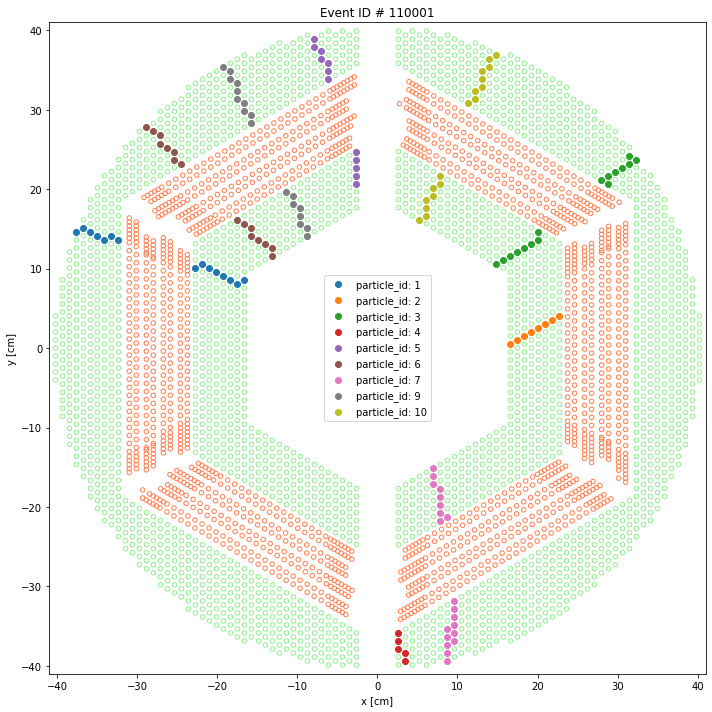

In [34]:
# plotting input_edges
plt.close('all')

# init subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

# detector layout
det = pd.read_csv("../src/stt.csv")
skw = det.query('skewed==0')
nkw = det.query('skewed==1') # one may look for +ve/-ve polarity
plt.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='lightgreen')
plt.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')

# feature data
x,y,_ = cylindrical_to_cartesian(r=gnn_eval_data.x[:, 0].detach().numpy(),
                                 phi=gnn_eval_data.x[:, 1].detach().numpy(),
                                 z=gnn_eval_data.x[:, 2].detach().numpy())
    
# particle track(s)
pids = np.unique(gnn_eval_data.pid)
for pid in pids:
    idx = gnn_eval_data.pid == pid
    ax.scatter(x[idx], y[idx], label='particle_id: %d' %pid)


# plotting params
ax.set_title('Event ID # %d' % event_id)
ax.set_xlabel('x [cm]', fontsize=10)
ax.set_ylabel('y [cm]', fontsize=10)
ax.set_xlim(-41, 41)
ax.set_ylim(-41, 41)
ax.grid(False)
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("input_edges.png")

In [35]:
from trkx_from_gnn_v1 import tracks_from_gnn

In [36]:
# predicted/reco tracks using DBSCAN
reco_tracks = tracks_from_gnn(hit_id, scores, senders, receivers, edge_score_cut=0.25, epsilon=0.25, min_samples=2)

/shared/adeel/anaconda3/envs/exatrkx-cpu/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


In [37]:
# let fetch hit_ids of a track, e.g. track_id == 
reco_tracks.query("track_id==-1")

,hit_id,track_id


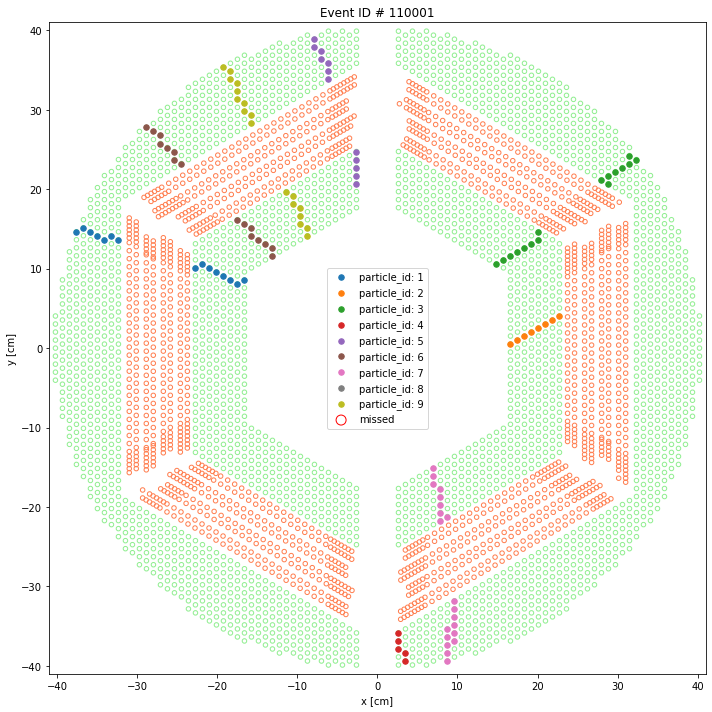

In [38]:
# plotting input_edges
plt.close('all')

# init subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# detector layout
det = pd.read_csv("../src/stt.csv")
skw = det.query('skewed==0')
nkw = det.query('skewed==1') # one may look for +ve/-ve polarity
plt.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='lightgreen')
plt.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')

# feature data
x,y,_ = cylindrical_to_cartesian(r=gnn_eval_data.x[:, 0].detach().numpy(),
                                 phi=gnn_eval_data.x[:, 1].detach().numpy(),
                                 z=gnn_eval_data.x[:, 2].detach().numpy())

# reco track(s)
pids = np.unique(reco_tracks.track_id)
for pid in pids:
    # print("pid: ", pid)
    idx = gnn_eval_data.pid == (pid+1)
    if pid >= 0:
        ax.scatter(x[idx], y[idx], s=30, label='particle_id: %d' %(pid+1))

# Missed hits
missed_hids= reco_tracks.query("track_id==-1")["hit_id"].values
hids = gnn_eval_data.hid.numpy()
idx = np.where(np.isin(hids, missed_hids))[0]
ax.scatter(x[idx], y[idx], facecolors='none', edgecolors='red', s=100, linewidth=1, label='missed')

# plotting params
ax.set_title('Event ID # %d' % event_id)
ax.set_xlabel('x [cm]', fontsize=10)
ax.set_ylabel('y [cm]', fontsize=10)
ax.set_xlim(-41, 41)
ax.set_ylim(-41, 41)
ax.grid(False)
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("input_edges.png")

In [39]:
np.unique(reco_tracks.track_id.values)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [40]:
missed_hid = reco_tracks.query("track_id==-1")["hit_id"]
missed_hids = missed_hid.values

In [41]:
missed_hids

array([], dtype=int32)

In [42]:
gnn_eval_data.hid

tensor([153,  25,  51,   1,  26, 154,  79,  52,   2,  80, 129,  27, 155,  53,
        173,   3,  81,  28, 130, 174,  54, 156,   4,  29,  82, 131, 175,  55,
        157,   5, 103,  30,  83,  56, 158, 132, 176,   6,  84,  31, 104, 159,
          7,  57, 133, 177,  32,  85, 105,  58, 160,  59,   8, 134, 178,  86,
        106, 179, 135, 180, 107, 136,  41,  16,  68,  42,  17,  95,  43,  69,
        117,  18,  96,  44, 145, 190,  70,  19, 118,  97, 146,  45, 124, 147,
        191,  71,  20, 119,  72,  98, 192,  46, 125, 120, 148,  73,  21,  74,
         99,  47, 193, 126, 121,  22,  75, 100, 149,  76,  48, 127, 122, 194,
         23, 101, 150,  77,  49, 128, 123, 195, 151,  24, 102, 152,  50,  78,
        196], dtype=torch.int32)

In [43]:
hids = gnn_eval_data.hid.numpy()

In [44]:
# let get indices of missed_hids in hids
idx = np.where(np.isin(hids, missed_hids))[0]

## Fixing the Srcipt using above EDA

NOTE: The script `tracks_from_gnn.py` is taken from the `exatrkx-iml2020/exatrkx/scripts` repository. It needs to be fixed according to `exatrkx-hsf` repo. 

Above disection of this script provides info on how to make it compatible with the `exatrkx-hsf` pipeline.

- **_Keep_**: _`tracks_from_gnn()`_
- **_Modify_**: _`process()`_
- **_Modify_**: _`__main__`_

In [45]:
# tracks_from_gnn() declared above

In [46]:
inputdir="../run_all/gnn_processed/pred"          # input from GNN stage as in test/pred
outputdir="../run_all/gnn_segmenting/seg_test"    # output of trkx_from_gnn.sh i.e. TrackCands
os.makedirs(outputdir, exist_ok=True)

In [47]:
# use os.listdir(path) to fetch files in arbitrary order
all_events = os.listdir(inputdir) # only list of files in arbitrary order
all_events = [os.path.join(inputdir, event) for event in all_events] # join path+files as a list
all_events = sorted(all_events) # sorted() over list/tuple iterator
all_events[:10]

['../run_all/gnn_processed/pred/110000',
 '../run_all/gnn_processed/pred/110001',
 '../run_all/gnn_processed/pred/110002',
 '../run_all/gnn_processed/pred/110003',
 '../run_all/gnn_processed/pred/110004',
 '../run_all/gnn_processed/pred/110005',
 '../run_all/gnn_processed/pred/110006',
 '../run_all/gnn_processed/pred/110007',
 '../run_all/gnn_processed/pred/110008',
 '../run_all/gnn_processed/pred/110009']

In [48]:
# OR, use glob.glob to fetch files (Note: glob.glob is wrapper around os.listdir)
all_files = glob.glob(os.path.join(inputdir, "*")) # list of files with path in arbitrary order
all_files = sorted(all_files) # sorted() over list/tuple iterator
all_files[:10]

['../run_all/gnn_processed/pred/110000',
 '../run_all/gnn_processed/pred/110001',
 '../run_all/gnn_processed/pred/110002',
 '../run_all/gnn_processed/pred/110003',
 '../run_all/gnn_processed/pred/110004',
 '../run_all/gnn_processed/pred/110005',
 '../run_all/gnn_processed/pred/110006',
 '../run_all/gnn_processed/pred/110007',
 '../run_all/gnn_processed/pred/110008',
 '../run_all/gnn_processed/pred/110009']

In [49]:
max_evts = 100
n_tot_files = len(all_files)
max_evts = max_evts if max_evts > 0 and max_evts <= n_tot_files else n_tot_files

In [50]:
# Let Peep into a Event
fname = all_files[0]

In [51]:
int(os.path.basename(fname))

110000

In [52]:
evtid = int(os.path.basename(fname))

In [53]:
print("event_id: {}".format(evtid))

event_id: 110000


In [54]:
# Load Event
gnn_data = torch.load(fname)
print("Length of Data: {}".format(len(gnn_data)))

Length of Data: 11


In [55]:
gnn_data.scores.shape[0]/2

475.0

In [56]:
# Get score, edge pair (sender, receiver) and hit_id from the Event
score = gnn_data.scores[:gnn_data.edge_index.shape[1]]
senders = gnn_data.edge_index[0]
receivers = gnn_data.edge_index[1]
hit_id = gnn_data.hid

In [57]:
def process(filename, outdir, score_name, **kwargs):
    """prepare a multiprocessing function for track building"""
    
    # get the event_id from the filename
    #evtid = int(os.path.basename(filename))  # [:-4] was to skip .npz extension, skipped in my case.
    evtid = os.path.basename(filename)
    
    # gnn_prcessed data by GNNBuilder Callback
    gnn_data = torch.load(filename)
    score = gnn_data.scores[:gnn_data.edge_index.shape[1]] # scores has twice the size of edge_index (flip(0) was used)
    senders = gnn_data.edge_index[0]
    receivers = gnn_data.edge_index[1]
    hit_id = gnn_data.hid
    
    # predicted tracks from the GNN stage
    predicted_tracks = tracks_from_gnn(hit_id, score, senders, receivers, **kwargs)
 
    # save reconstructed tracks into a file
    # PyTorch convention is to save tensors using .pt file extension
    # See https://pytorch.org/docs/stable/notes/serialization.html#preserve-storage-sharing
    torch.save(predicted_tracks, os.path.join(outdir, "{}.pt".format(evtid)))

In [58]:
# after success move to gnn_trkx.py
# process(fname, outputdir)